# Differential expression on C. elegans data

This notebook was contributed by Eduardo Beltrame [@Munfred](https://github.com/Munfred) and edited by Romain Lopez, Adam Gayoso, and Pierre Boyeau.

Processing and visualizing 89k cells from Packer et al. 2019 C. elegans 10xv2 single cell data

Original article:
`A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution`

https://science.sciencemag.org/content/365/6459/eaax1971.long

The anndata object we provide  has 89,701 cells and 20,222 genes.
It includes short gene descriptions from [WormBase](https://wormbase.org) that will show up when mousing over the interactive plots.

**Steps performed**:

1. Loading the data from anndata containing cell labels and gene descriptions
1. Training the model with batch labels for integration with scVI
1. Retrieving the scVI latent space and imputed values
1. Visualize the latent space with an interactive t-SNE plot using Plotly
1. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi

/home/pierre/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/home/pierre/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter("ignore")

In [3]:
scvi.__file__

'/home/pierre/scvi-tools/scvi/__init__.py'

In [4]:
adata = sc.read(
    "packer2019.h5ad",
    backup_url="https://github.com/Munfred/wormcells-site/releases/download/packer2019/packer2019.h5ad",
)
print(adata)

AnnData object with n_obs × n_vars = 89701 × 20222
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description'


### Take a look at the gene descriptions

The gene descriptions were taken using the [WormBase API](https://wormbase.org/about/userguide/for_developers#3--10).

In [5]:
display(
    adata.var.head().style.set_properties(
        subset=["gene_description"], **{"width": "600px"}
    )
)

,gene_id,gene_name,gene_description
index,,,
WBGene00010957,WBGene00010957,nduo-6,Is affected by several genes including daf-16; daf-12; and hsf-1 based on RNA-seq and tiling array studies. Is affected by six chemicals including Rotenone; Psoralens; and metformin based on RNA-seq and microarray studies.
WBGene00010958,WBGene00010958,ndfl-4,Is enriched in Psub2 based on RNA-seq studies. Is affected by several genes including daf-16; daf-12; and clk-1 based on RNA-seq and microarray studies. Is affected by six chemicals including Alovudine; Psoralens; and metformin based on RNA-seq studies.
WBGene00010959,WBGene00010959,nduo-1,Is an ortholog of human MT-ND1 (mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1). Is predicted to contribute to NADH dehydrogenase activity. Human ortholog(s) of this gene are implicated in Leber hereditary optic neuropathy and MELAS syndrome.
WBGene00010960,WBGene00010960,atp-6,"Is predicted to contribute to proton-transporting ATP synthase activity, rotational mechanism."
WBGene00010961,WBGene00010961,nduo-2,Is affected by several genes including hsf-1; clk-1; and elt-2 based on RNA-seq and microarray studies. Is affected by eight chemicals including stavudine; Zidovudine; and Psoralens based on RNA-seq and microarray studies.


### Selecting genes and loading data

We use the utility `scvi.data.poisson_gene_selection` to select genes according to their dropout rate, which is a simple and scalable approach to select genes.

This method was described by Andrews & Hemberg in the article `M3Drop: dropout-based feature selection for scRNASeq `:
https://academic.oup.com/bioinformatics/article/35/16/2865/5258099

This method modifies the adata to add the following fields:

```
highly_variable                   # boolean true for chosen genes
observed_fraction_zeros	       # fraction of observed zeros per gene
expected_fraction_zeros	       # expected fraction of observed zeros per gene
prob_zero_enriched_nbatches	   # If batch_key is given, this denotes in how many batches genes are detected as zero enriched
prob_zero_enrichment	          # Probability of zero enrichment, median across batches in the case of multiple batches
prob_zero_enrichment_rank         # Rank of the gene according to probability of zero enrichment
```

```{note}
Gene selection is an important step to obtain relevant cell representations with scVI.
Generally, selecting the top few thousands top-ranking genes predicted by a gene selection tool suffice to obtain good performance.

Increasing the number of selected genes may be required in some applications, e.g., to increase the number of considered genes for differential expression.
Note, however, that this will increase the time required to reach convergence and GPU memory load.
It may also require to tune scVI's model hyperparameters (see the autotune tutorial)

Alternatives to the Poisson gene selection can be used, e.g., via scanpy or seurat.
```

In [6]:
scvi.data.poisson_gene_selection(adata)
adata.var.head()

Sampling from binomial...: 100%|███████| 10000/10000 [00:00<00:00, 21289.98it/s]


,gene_id,gene_name,gene_description,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
index,,,,,,,,,
WBGene00010957,WBGene00010957,nduo-6,Is affected by several genes including daf-16;...,False,0.075685,0.002028,0,0.0775,15703.0
WBGene00010958,WBGene00010958,ndfl-4,Is enriched in Psub2 based on RNA-seq studies....,True,0.659680,0.623356,1,0.2507,19578.0
WBGene00010959,WBGene00010959,nduo-1,Is an ortholog of human MT-ND1 (mitochondriall...,True,0.201993,0.046608,1,0.1932,18978.0
WBGene00010960,WBGene00010960,atp-6,Is predicted to contribute to proton-transport...,True,0.138081,0.001848,1,0.1357,17804.0
WBGene00010961,WBGene00010961,nduo-2,Is affected by several genes including hsf-1; ...,True,0.468434,0.383116,1,0.2912,19835.0


In [7]:
adata = adata[:, adata.var["highly_variable"]]  # focus on selected genes
adata.layers[
    "counts"
] = adata.X.copy().tocsr()  # converts to CSR format, preserve counts

scvi.model.SCVI.setup_anndata(
    adata, layer="counts", batch_key="batch"
)  # prepare data for scVI

### Define and train the model

In [8]:
model = scvi.model.SCVI(
    adata, gene_likelihood="nb"
)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████| 400/400 [17:32<00:00,  2.62s/it, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████| 400/400 [17:32<00:00,  2.63s/it, v_num=1]


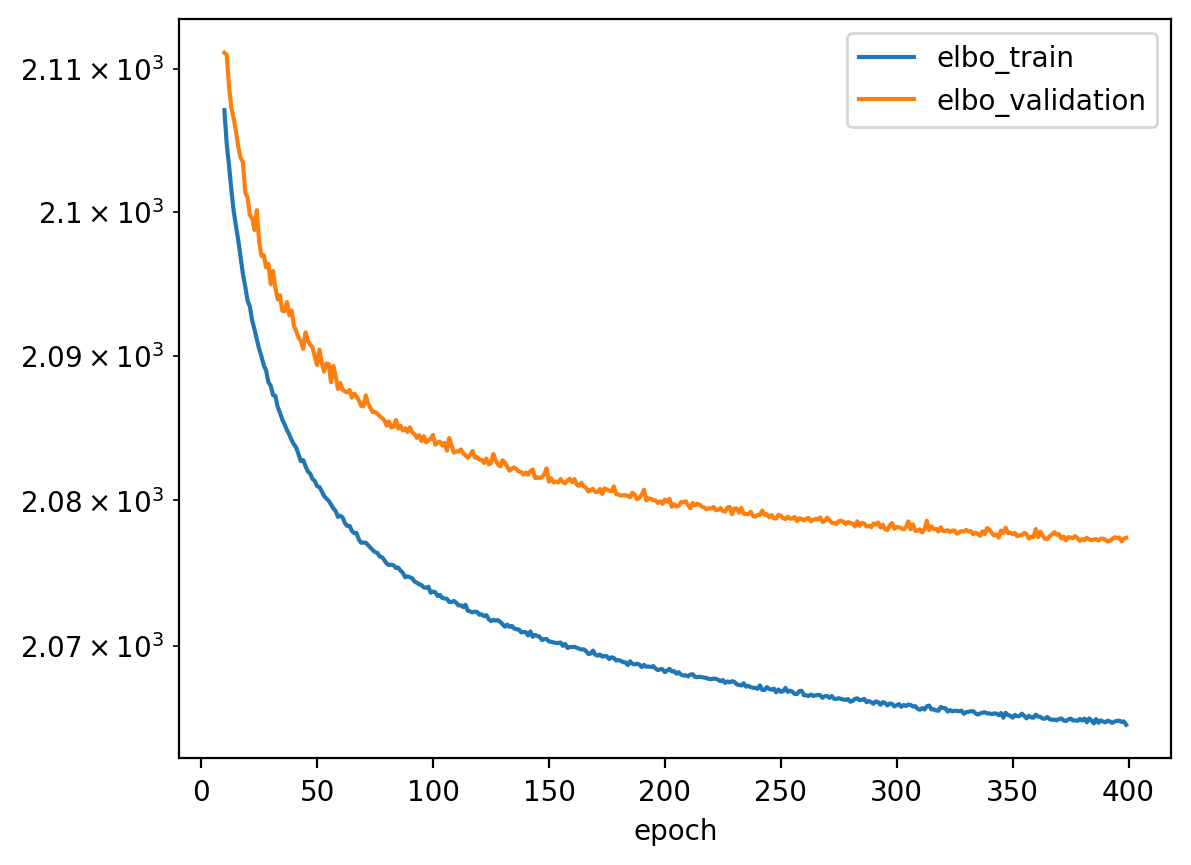

In [9]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

### Get the latent space and compute UMAP

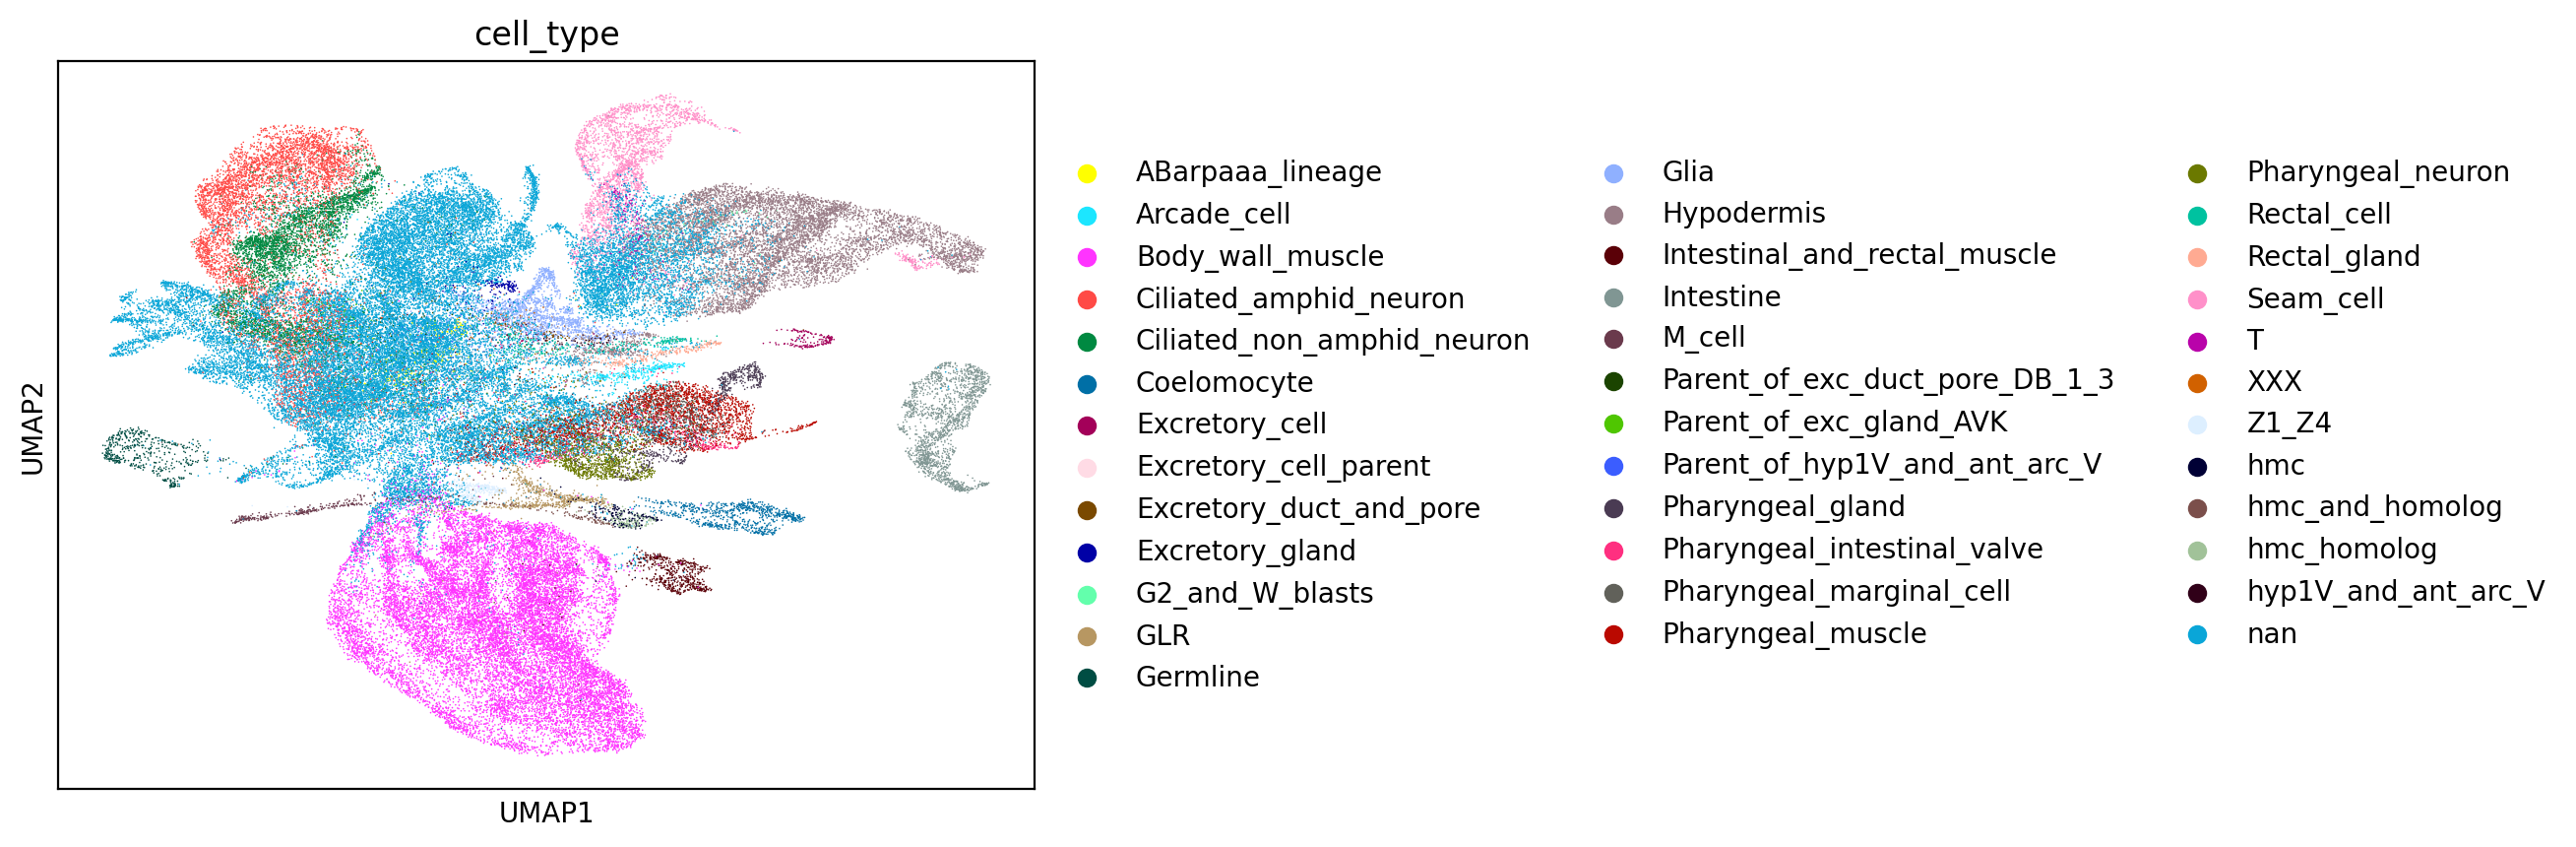

In [10]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

## Performing Differential Expression in scVI

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
1. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [11]:
# let's take a look at abundances of different cell types
adata.obs["cell_type"].value_counts()

cell_type
nan                               35052
Body_wall_muscle                  17520
Hypodermis                         7746
Ciliated_amphid_neuron             6090
Ciliated_non_amphid_neuron         4468
Seam_cell                          2766
Pharyngeal_muscle                  2562
Glia                               1857
Intestine                          1732
Pharyngeal_neuron                  1471
Pharyngeal_marginal_cell            911
Coelomocyte                         787
Pharyngeal_gland                    786
GLR                                 768
Intestinal_and_rectal_muscle        568
Germline                            499
Pharyngeal_intestinal_valve         493
Arcade_cell                         434
Z1_Z4                               372
Rectal_cell                         327
M_cell                              315
ABarpaaa_lineage                    273
Rectal_gland                        265
Excretory_cell                      215
Excretory_gland               

scVI provides several options to identify the two populations of interest.

In [12]:
cell_type_1 = "Ciliated_non_amphid_neuron"
cell_idx1 = adata.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Intestine"
cell_idx2 = adata.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

4468 cells of type Ciliated_non_amphid_neuron
1732 cells of type Intestine


### Basic principle

#### DE and log fold-changes

scVI can natively be used to perform differential expression analyses to compare populations of cells, as described [here](https://doi.org/10.1101/794289) and [there](https://doi.org/10.1101/2022.05.27.493625).
It achieves this by estimating the posterior distribution of the log fold-change (LFC) between subpopulations $A$ and $B$.
Specifically, for a given gene g, scVI calculates the LFC as the difference between the logarithm of its expression level in population A, denoted by $h_g^A$, and the logarithm of its expression level in population B, denoted by $h_g^B$.

The resulting value, denoted by $\beta_g$, provides insights into the expression patterns of gene $g$.
Values close to zero indicate that the gene is expressed similarly in both populations, positive values suggest upregulation in population A and negative values indicate downregulation in population A. This information can be used to better understand the biological mechanisms underlying the differences between the two cell populations.

#### DE testing

In addition to estimating the LFC, scVI can also detect which genes have *significant* expression patterns.
To tag which genes are differentially expressed, scVI tests the following competing hypotheses
$M_{1, g}: \beta_g \in [-\delta, \delta]$ and $M_{2, g}: \beta_g \in (-\infty, -\delta) \cup (\delta, \infty)$.
Here, $\delta$ denotes a small LFC threshold, such that $\beta_g \in [-\delta, \delta]$ is evidence that the gene is equally expressed in the two subpopulations.

Differentially expressed genes are identified by computing the posterior probability of $M_{2, g}$.

### Running DE analyses

#### Running and understanding a DE run

A simple DE analysis can then be performed using the following command

In [13]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
index,,,,,,,,,,,,,,,,,,,
WBGene00004372,1.0000,0.0000,18.420681,0.001084,0.000007,0.0,0.25,7.350241,7.449494,1.651103,-2.428346,13.769267,1.522145,0.049654,0.322739,0.039838,14.041124,0.089685,True
WBGene00020726,1.0000,0.0000,18.420681,0.000264,0.000007,0.0,0.25,5.458811,5.498209,1.154831,-1.458520,9.271249,0.323637,0.045035,0.241271,0.040416,2.908699,0.064477,True
WBGene00019641,1.0000,0.0000,18.420681,0.000697,0.000005,0.0,0.25,7.182933,7.323037,1.771782,-1.660804,13.730429,0.804168,0.041570,0.399060,0.032910,6.722792,0.063628,True
WBGene00008310,1.0000,0.0000,18.420681,0.000186,0.000006,0.0,0.25,4.941731,4.976462,1.273013,-0.270919,9.306834,0.221129,0.031755,0.166294,0.030023,2.125047,0.047162,True
WBGene00013560,1.0000,0.0000,18.420681,0.000038,0.001487,0.0,0.25,-4.943185,-4.943160,1.563259,-10.487162,2.982615,0.035586,8.210736,0.030886,0.898961,0.340249,12.132426,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00017829,0.5846,0.4154,0.341686,0.000109,0.000107,0.0,0.25,0.036961,0.057220,0.509930,-2.452420,1.805105,0.125112,0.711317,0.103626,0.464203,1.062658,1.015743,False
WBGene00011116,0.5696,0.4304,0.280219,0.000290,0.000256,0.0,0.25,0.169691,0.184282,0.391379,-1.551293,1.813447,0.356761,1.845267,0.275067,0.763279,2.977354,2.605500,False
WBGene00022044,0.5618,0.4382,0.248470,0.000175,0.000162,0.0,0.25,0.147381,0.108897,0.495938,-2.250889,3.307567,0.189124,1.164550,0.163608,0.618938,1.598889,1.587371,False


This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

#### Main hyperparameters

Additional parameters can be tuned in specific applications.

1. **weights**, which can correspond to <span style="color:#eb5e34">"uniform"</span> or <span style="color:#eb5e34">"importance"</span> specify how normalized gene expressions in the two subpopulations are computed. The <span style="color:#eb5e34">"importance"</span> flavor is specifically designed to provide FDR-calibrated gene sets, but may be overkill if you only aim to rank genes (via their LFC for instance).
1. **filter_outlier_cells** filters out outlier cells prior to computing normalized gene expressions. It is important to set this parameter to `True` when `weights='importance'`.
1. **delta** allows to specify $\delta$, which is used to detect differentially expressed genes. It can also be set automatically using `delta=None`
1. **pseudocounts**, which is zero by default, but can be set to a small value (e.g., 1e-6) when many detected DE genes are seldom expressed in the compared populations.
1. **batch_correction**, which should be set to `True` to account for batch effects. This only makes sense when `idx1` and `idx2` denote cells coming from overlapping batches.

The exact function of these parameters is described [here](https://doi.org/10.1101/2022.05.27.493625).

### Volcano plot of change mode DE with p-values

In [14]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...: 100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,log10_pscore,gene_id,gene_name,gene_description,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
index,,,,,,,,,,,,,,,,,,,,,
WBGene00021547,1.0000,0.0000,18.420681,0.000362,0.000022,0.0,0.25,4.154714,4.204091,0.868408,...,-inf,WBGene00021547,Y44E3A.1,Is enriched in PLM and seam cell based on RNA-...,True,0.825676,0.815535,1,0.1485,18132.0
WBGene00004372,0.9998,0.0002,8.516543,0.000990,0.000007,0.0,0.25,7.147630,7.248559,1.621604,...,-3.698796,WBGene00004372,rig-5,Is an ortholog of human LSAMP (limbic system a...,True,0.928574,0.814163,1,0.1757,18701.0
WBGene00269373,0.9998,0.0002,8.516543,0.000682,0.000006,0.0,0.25,6.950307,6.988183,1.731167,...,-3.698796,WBGene00269373,M01D1.12,Is predicted to encode a protein with the foll...,True,0.915954,0.870112,1,0.1197,17346.0
WBGene00007286,0.9998,0.0002,8.516543,0.001035,0.000007,0.0,0.25,6.942219,7.025548,1.981845,...,-3.698796,WBGene00007286,C04A11.2,Is enriched in dopaminergic neurons based on t...,True,0.891239,0.826348,1,0.1521,18219.0
WBGene00012317,0.9998,0.0002,8.516543,0.000206,0.000018,0.0,0.25,3.663368,3.688221,1.124686,...,-3.698796,WBGene00012317,ztf-6,Is predicted to have nucleic acid binding acti...,True,0.709067,0.674314,1,0.2305,19383.0


In [15]:
de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata.var, how="inner")

DE...: 100%|██████████████████████████████████████| 1/1 [00:51<00:00, 51.36s/it]


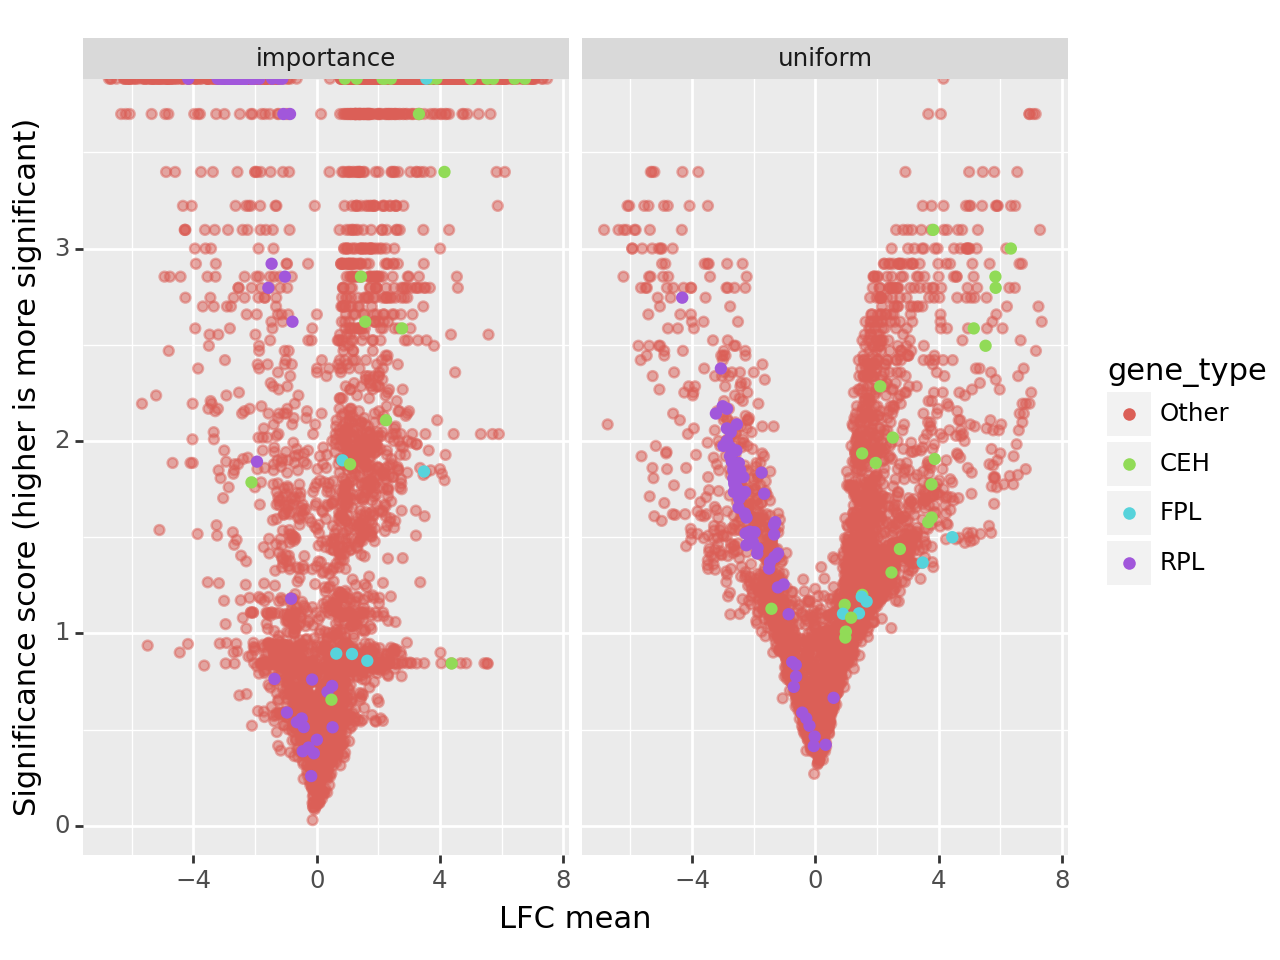

<Figure Size: (640 x 480)>

In [16]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
de_comp.loc[lambda x: x["gene_name"].str.contains("rpl-"), "gene_type"] = "RPL"
de_comp.loc[lambda x: x["gene_name"].str.contains("ceh-"), "gene_type"] = "CEH"
de_comp.loc[lambda x: x["gene_name"].str.contains("flp-"), "gene_type"] = "FPL"

(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)

Contrary to the `uniform` flavor, the `importance` flavor returns sharper posterior probability scores (posterior probability near 0 or 1, respectively in case of equal expression or differential expression).

### Heatmap of top expressed genes

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

In [17]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...: 100%|████████████████████████████████████| 37/37 [02:14<00:00,  3.64s/it]


We focus on cell-types with at least 500 cells, and which have annotations to facilitate heatmap visualization

In [18]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [19]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)["index"]
    .unique()
)

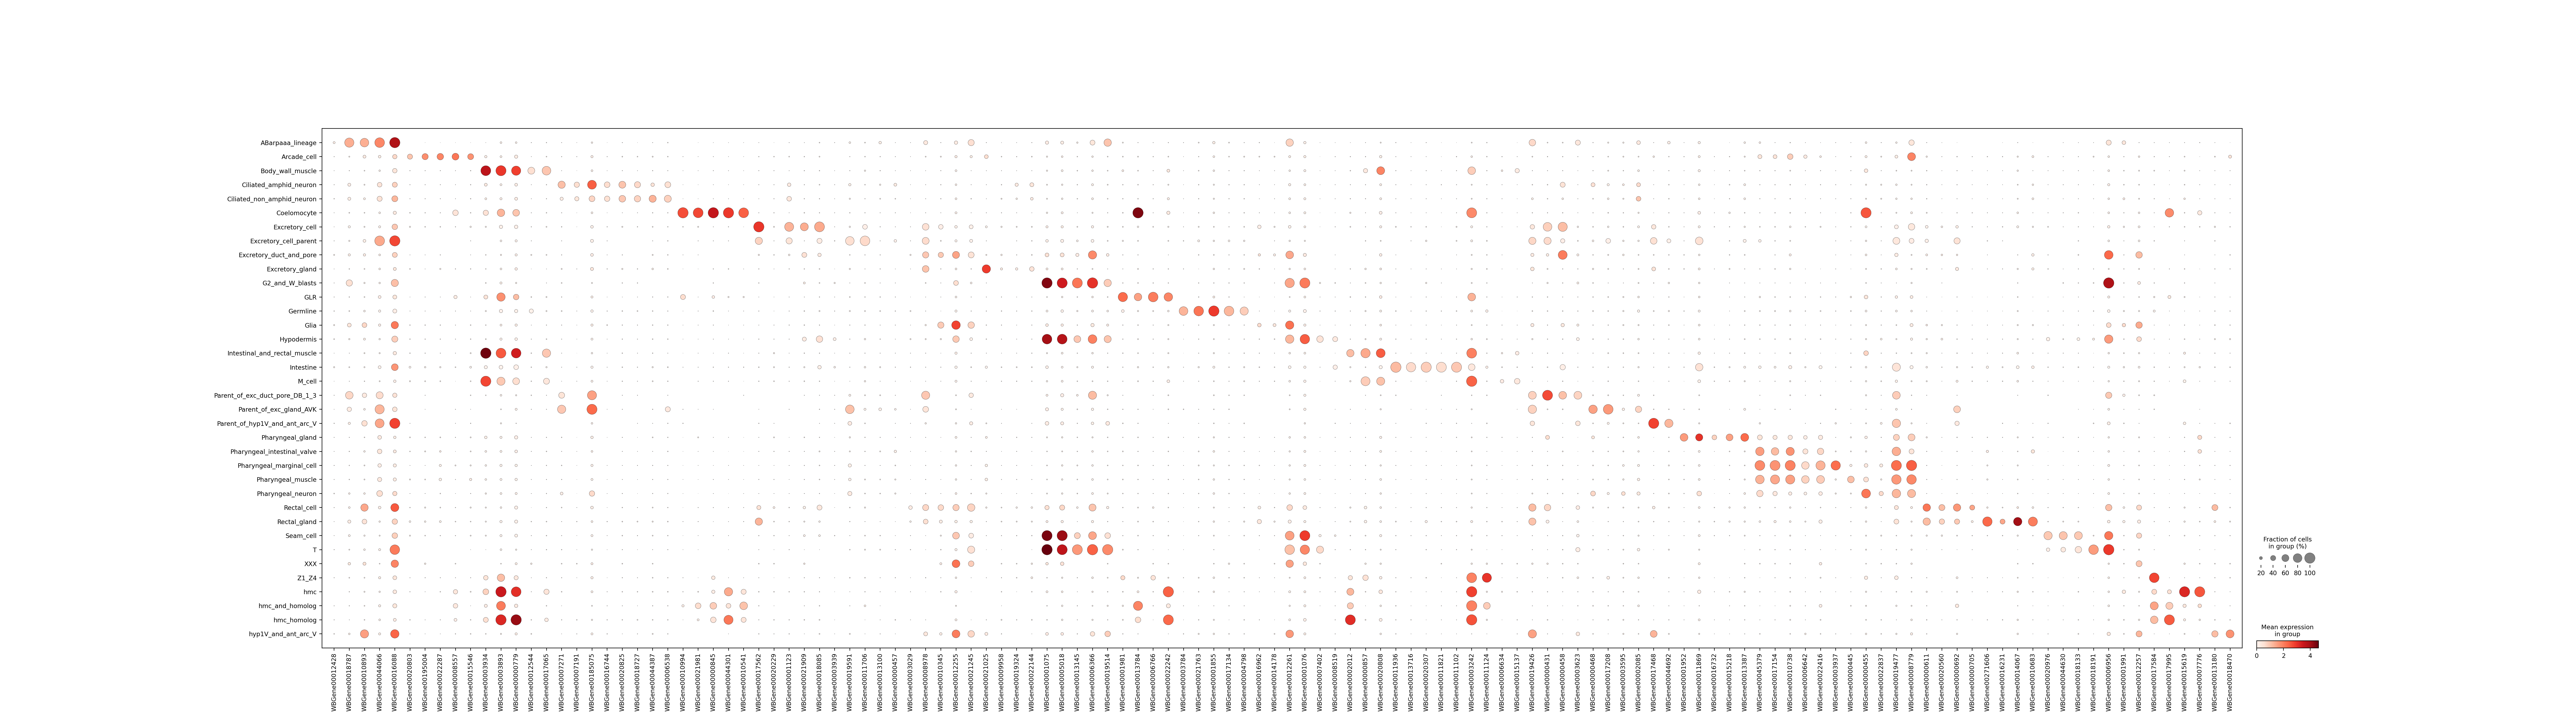

In [20]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(adata_log, marker_genes, groupby="cell_type")